In [1]:
# 독립변수 종속변수 모두 수치형이어야 딥러닝이 돌아간다.

# - 원태찬 작성.
# : 팀프로젝트를 했었던 내용이었지만 이미지 분류 딥러닝은 잃어버린 파일이었어서 혼자 작성함.

# - training(학습), validation(검증)의 2가지 데이터가 있다.
import os
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import _split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from keras.preprocessing import image
import re
from sklearn.preprocessing._label import LabelEncoder

# json 파일 읽어서 DataFrame화 하기
pd.set_option('display.max_columns', None)

# 마지막에 validation -> training
path = 'C:/Users/user/Desktop/CNN/유형별 두피 이미지/Training/label_training/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.json')]

import json

dict_list = []
for i in file_list_py:
    for line in open((path+i),"r"):
        dict_list.append(json.loads(line))
df = pd.DataFrame(dict_list)
print(len(df))

# 0->0, 1,2,3->1로 바꾸는 작업
for i in range(1,7):
  df[f'value_{i}'] = df[f'value_{i}'].map({'0':0,'1':1,'2':1,'3':1})
df['구분'] = '복합성'


# label 지정
# +  : 123
# -   : 0
# +- : 0123
for i in range(len(df)):
    if df.iloc[i][2:8].sum() == 0:
        df.loc[i, '구분'] = '양호'
    elif (df['value_1'][i] == 1) & (df['value_2'][i] == 0) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '건성'
    elif (df['value_1'][i] == 0) & (df['value_2'][i] == 1) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '지성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] == 0) & (df['value_3'][i] == 1) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '민감성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] == 1) & (df['value_3'][i] == 1) & (df['value_4'][i] == 0) & (df['value_5'][i] in [0,1]) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '지루성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] in [0,1]) & (df['value_3'][i] == 0) & (df['value_4'][i] == 1) & (df['value_5'][i] in [0,1]) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '염증성'
    elif (df['value_1'][i] in [0,1]) & (df['value_2'][i] in [0,1]) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 1) & (df['value_6'][i] == 0):
        df.loc[i, '구분'] = '비듬성'
    elif (df['value_1'][i] == 0) & (df['value_2'][i] == 0) & (df['value_3'][i] == 0) & (df['value_4'][i] == 0) & (df['value_5'][i] == 0) & (df['value_6'][i] == 1):
        df.loc[i, '구분'] = '탈모성'
    else:
        df.loc[i, '구분'] = '복합성'


print('양호 :', (df['구분'] == '양호').value_counts()[True])
print('건성 :', (df['구분'] == '건성').value_counts()[True])
print('지성 :', (df['구분'] == '지성').value_counts()[True])
print('민감성 :', (df['구분'] == '민감성').value_counts()[True])
print('지루성 :', (df['구분'] == '지루성').value_counts()[True])
print('염증성 :', (df['구분'] == '염증성').value_counts()[True])
print('비듬성 :', (df['구분'] == '비듬성').value_counts()[True])
print('탈모성 :', (df['구분'] == '탈모성').value_counts()[True])
print('복합성 :', (df['구분'] == '복합성').value_counts()[True])

image_path = "C:/Users/user/Desktop/CNN/유형별 두피 이미지/Training/feature_training/"
image_files = [file for file in os.listdir(image_path) if file.endswith('.jpg')]
# 이미지 파일을 NumPy 배열로 변환
images = []
for file_name in image_files:
    img = Image.open(os.path.join(image_path, file_name)).resize((200, 200))
    images.append(np.array(img))
images = np.array(images)

# 이미지 파일 이름과 DataFrame을 매칭
file_df = pd.DataFrame(image_files, columns=["image_file_name"])
merged_df = pd.merge(df, file_df, on='image_file_name', how='inner')

# 라벨 인코딩 및 원-핫 인코딩
labels = merged_df['구분'].values
onehot_encoder = OneHotEncoder(sparse=False)
labels_encoded = onehot_encoder.fit_transform(labels.reshape(-1, 1))

print(images.shape, labels_encoded.shape)

# 이미지
# features: 이미지  (72342장)
# labels: 라벨링 데이터  (72342개)

"""
양호 : 534
건성 : 1576
지성 : 7050
민감성 : 4879
지루성 : 28143
염증성 : 502
비듬성 : 7491
탈모성 : 148
복합성 : 22019
"""

72342
양호 : 534
건성 : 1576
지성 : 7050
민감성 : 4879
지루성 : 28143
염증성 : 502
비듬성 : 7491
탈모성 : 148
복합성 : 22019


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(72342, 200, 200, 3) (72342, 9)


'\n양호 : 534\n건성 : 1576\n지성 : 7050\n민감성 : 4879\n지루성 : 28143\n염증성 : 502\n비듬성 : 7491\n탈모성 : 148\n복합성 : 22019\n'

In [2]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# 데이터 나누기
# test_size=0.3은 전체 데이터 중 30%를 테스트 데이터로, 70%는 훈련 데이터로 사용된다는 뜻이다.
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.3, random_state=42)

print(x_train.shape, y_train.shape)  # 훈련 데이터의 크기 출력
print(x_test.shape, y_test.shape)  # 테스트 데이터의 크기 출력

(50639, 200, 200, 3) (50639, 9)
(21703, 200, 200, 3) (21703, 9)


In [22]:
# EfficientNet
# 개요: 2019년에 Google AI에서 발표한 EfficientNet은 확장성(scalability)이 뛰어난 모델입니다. 이 모델은 기본적인 구조를 다양한 크기로 확장하여 작은 모델부터 큰 모델까지 여러 범위의 계산 복잡도와 성능을 아우를 수 있습니다.
# 특징: EfficientNet은 깊이(depth), 너비(width), 해상도(resolution)의 세 가지 차원에서 모델의 크기를 균형 있게 조정합니다. 이를 통해 비교적 적은 파라미터로도 높은 정확도를 달성합니다.
# 데이터셋 크기 : 작은 데이터셋에서는 EfficientNet 같은 모델이 더 적합할 수 있습니다.

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
transfer_model = EfficientNetB0(weights='imagenet', include_top=False,  input_shape=(200,200,3))
transfer_model.trainable=False


model_EfficientNetB0 = Sequential([
    transfer_model,
    Conv2D(128, kernel_size=(3,3), input_shape=(200,200,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.3),  # 드롭아웃 비율을 조정하여 오버피팅 방지 및 계산량 감소

    Flatten(),
    Dense(256, activation='relu'),  # 유닛 수 감소
    Dense(128, activation='relu'),  # 유닛 수 감소
    Dense(9, activation='softmax')  # 최종 출력 레이어
])


In [23]:
# 컴파일
# Adam(Adaptive Moment Estimation)은 경사하강법(Optimization) 알고리즘 중 하나로, 딥러닝에서 가장 많이 사용되는 최적화 알고리즘 중 하나이다.
# 경사하강법은 모델의 손실 함수에 최솟값을 구하는 것을 뜻한다.
# categorical_crossentropy는 분류 문제에서 많이 사용되는 손실 함수 중 하나임.
# metrics는 모델의 평가 지표로써 acc는 정확도를 사용한다는 뜻임.
# Adam 옵티마이저 인스턴스 생성 시 학습률을 0.001로 설정

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001)

# 모델 컴파일 시, 생성한 Adam 인스턴스 사용
model_EfficientNetB0.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
earlystop = EarlyStopping(monitor='val_loss',  # 모니터링 대상 성능 지표
                          patience=3,  # 성능 지표가 개선되지 않는 에포크를 몇 번이나 허용할 것인가
                          verbose=1,  # 진행 상황을 출력
                          restore_best_weights=True)  # 가장 좋은 모델의 가중치를 복원할지 여부

# 모델 학습
history_model_EfficientNetB0 = model_EfficientNetB0.fit(x_train, y_train,
                                      epochs=10,
                                      batch_size=512,
                                      verbose=1,
                                      validation_split=0.2,
                                      callbacks=[earlystop])  # 콜백 리스트에 earlystop 추가

#  best epoch = loss: 1.1819 - accuracy: 0.5436 - val_loss: 1.2361 - val_accuracy: 0.5242
# 정확도 : 52.42%

Epoch 1/10
80/80 [==============================] - 881s 11s/step - loss: 1.4708 - accuracy: 0.4468 - val_loss: 1.2874 - val_accuracy: 0.5128
Epoch 2/10
80/80 [==============================] - 891s 11s/step - loss: 1.2695 - accuracy: 0.5081 - val_loss: 1.2408 - val_accuracy: 0.5222
Epoch 3/10
80/80 [==============================] - 899s 11s/step - loss: 1.2288 - accuracy: 0.5262 - val_loss: 1.2501 - val_accuracy: 0.5185
Epoch 4/10
80/80 [==============================] - 884s 11s/step - loss: 1.1981 - accuracy: 0.5363 - val_loss: 1.2716 - val_accuracy: 0.5239
Epoch 5/10
80/80 [==============================] - 881s 11s/step - loss: 1.1819 - accuracy: 0.5436 - val_loss: 1.2361 - val_accuracy: 0.5242
Epoch 6/10
80/80 [==============================] - 889s 11s/step - loss: 1.1549 - accuracy: 0.5552 - val_loss: 1.2526 - val_accuracy: 0.5136
Epoch 7/10
80/80 [==============================] - 889s 11s/step - loss: 1.1244 - accuracy: 0.5642 - val_loss: 1.2376 - val_accuracy: 0.5253
Epoch 

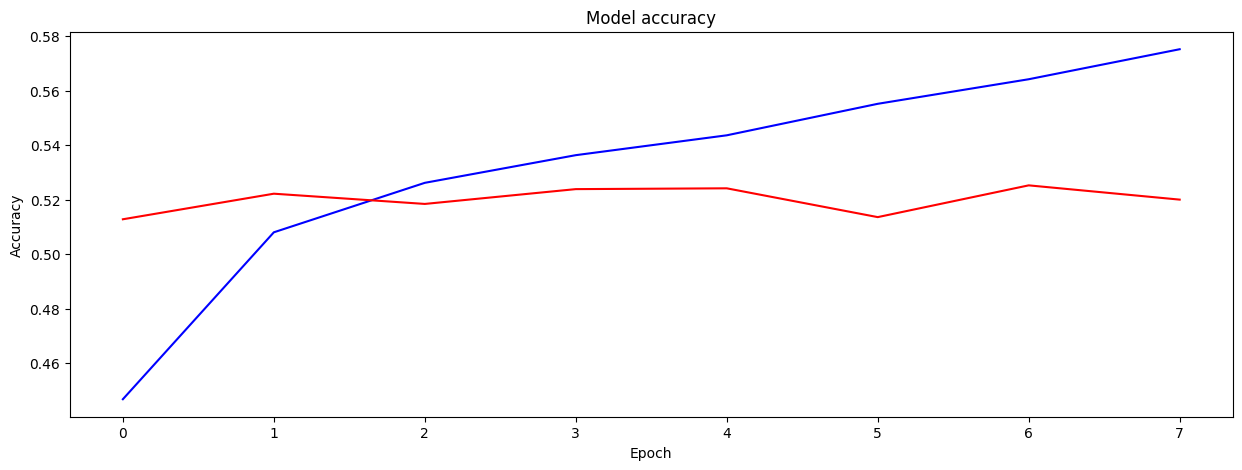

In [25]:
plt.figure(figsize=(15,5))
plt.plot(history_model_EfficientNetB0.history['accuracy'], color='blue')
plt.plot(history_model_EfficientNetB0.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

1/1 [==============================] - 0s 40ms/step
실제 두피 종류: 지루성
예측 두피 종류: 비듬성


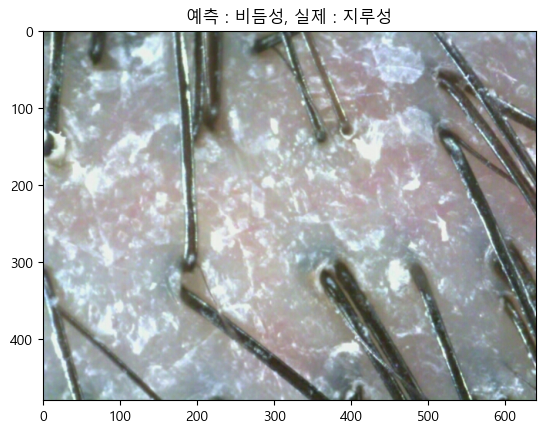

In [32]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict_and_display(img_path, model, classes, actual_class_index=None):
    # 이미지 불러오기 및 전처리
    img = Image.open(img_path)
    img_array = np.array(img.resize((200, 200)))
    img_array = img_array.reshape(1, 200, 200, 3)  # 모델에 넣기 위해 4차원으로 변환

    # 예측하기
    pred = model.predict(img_array)
    pred_class_index = np.argmax(pred)
    pred_class = classes[pred_class_index]

    # 실제값 출력
    if actual_class_index is not None:
        actual_class = classes[actual_class_index]
        print(f'실제 두피 종류: {actual_class}')
    else:
        print("실제 두피 종류 정보가 제공되지 않았습니다.")

    print(f'예측 두피 종류: {pred_class}')

    # 이미지 출력
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.imshow(img)
    plt.title(f'예측 : {pred_class}, 실제 : {actual_class}')
    plt.show()

# 예측할 이미지의 경로
# 실제값 : 지루성
img_path = 'C:/Users/user/Desktop/CNN/유형별 두피 이미지/Validation/원천/[원천]모낭사이홍반_2.중등도/0013_A2LEBJJDE00060O_1606551038976_6_BH.jpg'
# 두피 종류 레이블
classes = ['양호', '건성', '지성', '민감성', '지루성', '염증성', '비듬성', '탈모성', '복합성']

actual_class_index = 4  # '지루성'의 인덱스

# 예측 및 결과 출력
predict_and_display(img_path, model_EfficientNetB0, classes, actual_class_index)
